# Classification with Support Vector Machines

The goal of today’s lab session is to see the role of the kernel trick and the use of SVM.

To achieve this we will again consider the noisy sine function, which we considered previously for the regression problem. We tune this problem into classification by the rule:

$(x_1, x_2) \text{ belongs to } \left\{\begin{array}{ll}
1 & \text{, if } x_2 > f(x_1) \\
0 & \text{, if } x_2 \leq f(x_1)
\end{array}\right.$

where $f(x)$ is our (optionally noisy) sine function. We can then generate some number of points and label them accordingly.

We will again use scikit-learn, see the useful links:

- [SVM Module background](https://scikit-learn.org/stable/modules/svm.html)
- [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Example](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html)

### The tasks are
1. Generate a set of labeled points without noise. Try the SMV with linear kernel (no kernel trick). You should be able to see that the correct classification is not possible because the classes are not linearly separable in this space.
2. Next, you are supposed to suggest the kernel that extends the dimensionality of the feature space (from 2 to 3) so that the sets become linearly separable.
3. Consider the case, in which you also have an unknown phase in the sine function. Try the method developed in task 2 again. Explain why this does not work anymore (for non-zero phase). Try to find the appropriate kernel for the case of arbitrary phase, i.e. the transformation (to 4D) space that makes the trick.
4. Now, increase the level of noise. What does effectively happen with the solution? Discuss and make conclusions.

# Necessary imports and definition of our function

Here we define and plot our noisy sine function and the classifiers based on it

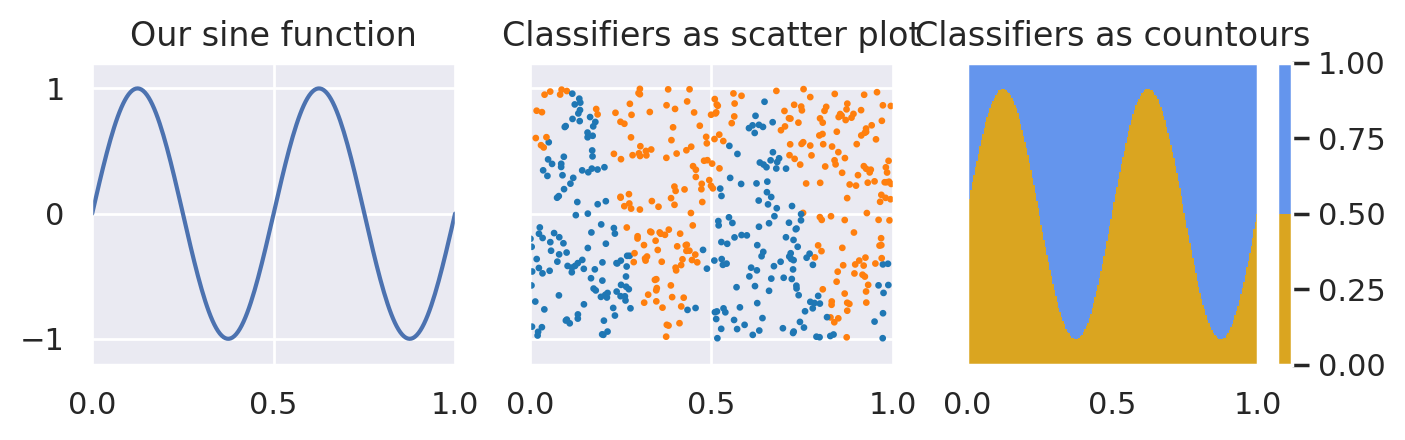

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
import numpy as np
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("deep")
sns.set(font='sans-serif')

from matplotlib.colors import Normalize, ListedColormap
from matplotlib.cm import Paired, get_cmap, ScalarMappable

from sklearn import svm

class_cmap = ListedColormap(['goldenrod', 'cornflowerblue'])


def func(x, noise_amplitude=0.0, number_of_cycles=1.0, phase=0.0):
    data = np.sin(2*np.pi*(x+phase)*number_of_cycles)
    noise = np.random.uniform(-noise_amplitude/2, noise_amplitude/2, size=x.shape)
    
    return data + noise


def classify(X, **kwargs):
    X = np.asarray(X)
    assert X.shape[1] == 2, 'X must have size 2 on axis on, so that it can be interpreted as a point in 2D'
    
    boundary = func(X[:, 0], **kwargs)
    classifier = np.where(X[:, 1] > boundary, 1, 0)
    
    return classifier


# For convenience you might or might not want to plot it
do_plot = True
if do_plot:
    x = np.linspace(0, 1, 200)
    fig, axes = plt.subplots(1, 3, figsize=(8,2), sharex=True, sharey=True)
    
    kwargs = dict(noise_amplitude=0.0, number_of_cycles=2.0, phase=0.0)
    axes[0].plot(x, func(x, **kwargs))
    axes[0].set_title('Our sine function')
    
    norm = Normalize(0, 10)
    cmap = get_cmap('tab10')
    
    X = np.random.rand(500, 2)
    X[:, 1] = 2*(X[:, 1]-0.5)
    Z = classify(X, **kwargs)
    axes[1].scatter(X[:, 0], X[:, 1], 2, c=cmap(norm(Z)))
    axes[1].set_title('Classifiers as scatter plot')
    
    x = np.linspace(0, 1, 200)
    y = np.linspace(-1.2, 1.2, 200)
    xx, yy = np.meshgrid(x, y)
    
    X = np.stack([xx.ravel(), yy.ravel()], axis=1)
    Z = classify(X, **kwargs)
    
    p = axes[2].pcolormesh(xx, yy, Z.reshape((x.size, y.size)), cmap=class_cmap, shading='nearest')
    fig.colorbar(p, ax=axes[2])
    axes[2].set_title('Classifiers as countours')

## Define a helper functions for visualization

In [2]:
def visualize_clf(clf, X_train, y_train, ax=None, show_decision_function=False):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 3))
        
    train_kwargs = dict(s=6, lw=0.0, edgecolors='k')
    supp_kwargs = dict(s=8, lw=0.5, edgecolors='k')
    cmap_vec = Paired
    
    # Get support vectors
    support_vectors = X_train[clf.support_, :]
    support_targets = y_train[clf.support_]
    
    # Scatter training data, marking support vectors
    # The * operator on a matrix unpacks its rows, thus
    # > (*X_train.T, ...)
    # is equivalent to
    # > (X_train[:, 0], X_train[:, 1], ...)
    ax.scatter(*X_train.T, c=y_train, zorder=10, cmap=cmap_vec, **train_kwargs)
    ax.scatter(*support_vectors.T, c=support_targets, zorder=11, cmap=cmap_vec, **supp_kwargs)
    ax.scatter([], [], color=cmap_vec(1.0), **train_kwargs, label='Training data (+1)')
    ax.scatter([], [], color=cmap_vec(0.0), **train_kwargs, label='Training data (0)')
    ax.scatter([], [], color=cmap_vec(1.0), **supp_kwargs, label='Support vectors (+1)')
    ax.scatter([], [], color=cmap_vec(0.0), **supp_kwargs, label='Support vectors (0)')

    # Calculate decision function on meshgrid of values
    X1, X2 = np.meshgrid(np.linspace(0, 1, 200), np.linspace(-1, 1, 200))
    X = np.stack((X1.ravel(), X2.ravel()), axis=1)
    y = clf.decision_function(X)
    Y = y.reshape(X1.shape)
    
    # Put the result into a color plot
    Y_class = np.where(Y > 0, 1, 0)
    if not show_decision_function:
        norm = Normalize(0, 1)
        cmap = class_cmap
    else:
        norm = Normalize(-2, 2)
        cmap = get_cmap('viridis')
        
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    if show_decision_function:
        cbar.set_label('Decision function')
    else:
        cbar.set_label('Predicted class')
        
    ax.pcolormesh(X1, X2, Y if show_decision_function else Y_class, norm=norm, cmap=cmap, shading='nearest')
    ax.contour(X1, X2, Y, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])
    ax.plot([], '-k', label='Boundary')
    ax.plot([], '--k', label='Margin boundary')

    score = clf.score(X_train, y_train)
    ax.set_title(f'Score {score:.3f}')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    ax.legend(bbox_to_anchor=(1.30, 1), loc='upper left')
    
    

def visualize_clf_3d(clf, transform, X_train, y_train, ax=None, show_decision_function=False):
    if ax is None:
        fig = plt.figure(figsize=(4, 3))
        ax = fig.add_subplot(111, projection='3d')
        
    train_kwargs = dict(s=6, lw=0.0, edgecolors='k')
    supp_kwargs = dict(s=8, lw=0.5, edgecolors='k')
    cmap_vec = Paired
    
    # Get support vectors
    X_transformed = transform(X_train)
    support_vectors = X_transformed[clf.support_, :]
    support_targets = y_train[clf.support_]
    
    # Scatter training data, marking support vectors
    ax.scatter(*X_transformed.T, c=y_train, zorder=10, cmap=cmap_vec, **train_kwargs)
    ax.scatter(*support_vectors.T, c=support_targets, zorder=11, cmap=cmap_vec, **supp_kwargs)
    ax.scatter([], [], color=cmap_vec(1.0), **train_kwargs, label='Training data (+1)')
    ax.scatter([], [], color=cmap_vec(0.0), **train_kwargs, label='Training data (0)')
    ax.scatter([], [], color=cmap_vec(1.0), **supp_kwargs, label='Support vectors (+1)')
    ax.scatter([], [], color=cmap_vec(0.0), **supp_kwargs, label='Support vectors (0)')

    # Calculate decision function on meshgrid of values
    X1, X2 = np.meshgrid(np.linspace(0, 1, 100), np.linspace(-1, 1, 100))
    X = np.stack((X1.ravel(), X2.ravel()), axis=1)
    y = clf.decision_function(X)
    X3 = transform(X)[:, 2].reshape(X1.shape)
    Y = y.reshape(X1.shape)
    
    
    # Put the result into a color plot
    Y_class = np.where(Y > 0, 1, 0)
    if not show_decision_function:
        norm = Normalize(0, 1)
        cmap = class_cmap
    else:
        norm = Normalize(-2, 2)
        cmap = get_cmap('viridis')
        
    ax.scatter(*transform(X).T, c=y, zorder=10, cmap=cmap, norm=norm, s=1, alpha=0.05)
        
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')
    if show_decision_function:
        cbar.set_label('Decision function')
    else:
        cbar.set_label('Predicted class')

    score = clf.score(X_train, y_train)
    ax.set_title(f'Score {score:.3f}')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    
    ax.legend(bbox_to_anchor=(1.30, 1), loc='upper left')

## Task 1

Try out the SVM using a linear kernel. It should be equivalent to use either

```python
svm.SVC(kernel='linear')
```

or the custom kernel

```python
svm.SVC(kernel=custom_kernel)
```

You should be able to see that the correct classification is not possible because the classes are not linearly separable in this space.

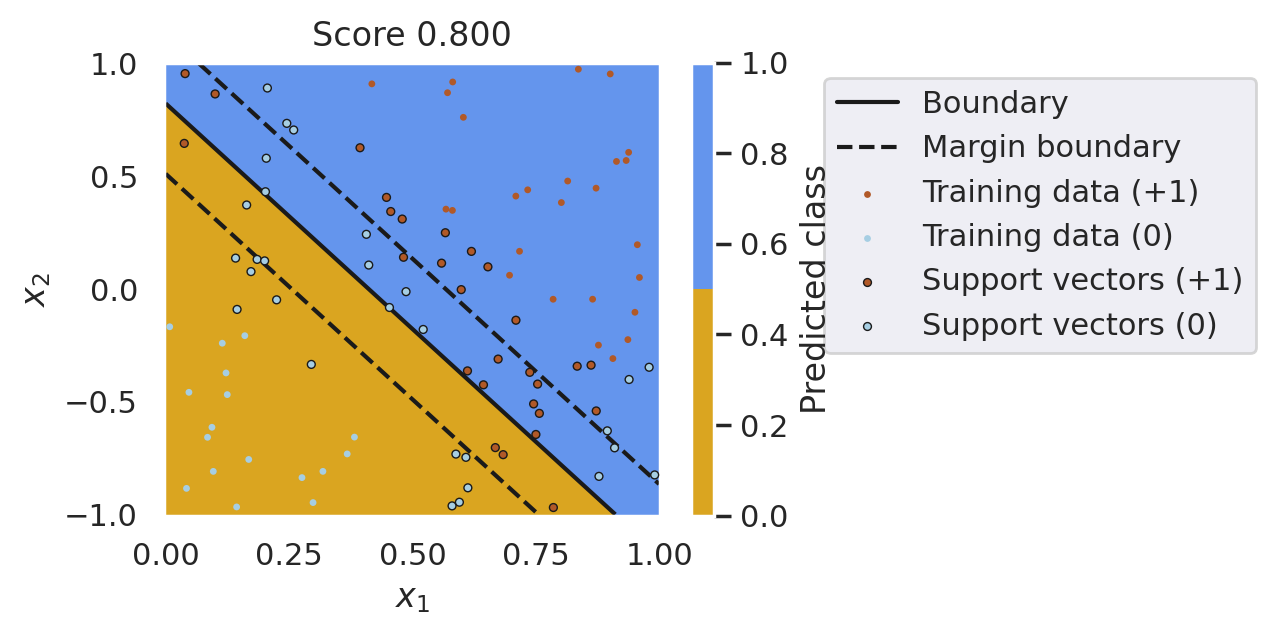

In [4]:
def custom_kernel(X1, X2):
    """
    X1: shape (n_samples_1, 2)
    X2: shape (n_samples_2, 2)
    
    return: (n_samples_1, n_samples_2)
    """
    K = np.dot(X1, X2.T)
    return K


# Generate random samples with the components 0 < x < 1, -1 < y < 1
X = np.random.rand(100, 2)
X[:, 1] = 2*(X[:, 1]-0.5)

y = classify(X, noise_amplitude=0.0, number_of_cycles=1.0, phase=0.0)

clf = svm.SVC(kernel=custom_kernel)
clf.fit(X, y)
    
visualize_clf(clf, X, y, show_decision_function=False)

### Bonus:
For reference this is how one can define an RBF kernel. You can verify that training with

```python
svm.SVC(kernel='rbf')
```

and

```python
svm.SVC(kernel=rbf_kernel)
```

is equivalent, but this won't in general give a satisfactory solution to this task.

In [ ]:
def rbf_kernel(X1, X2):
    """ Should be equivalent to SVC(kernel='rbf')
    """
    n_features = X1.shape[1]
    gamma = 1.0/(n_features * X1.var()) # This is equivalent to the default argument gamma = 'scale' to SVC
    
    d = X1.reshape((-1, 1, n_features)) - X2.reshape((1, -1, n_features))
    K = np.exp(-gamma*np.sum(d**2, axis=2))
    return K

## Task 2

Now, try extending the dimensionality of the feature space from 2 to 3, so that the sets become linearly sepearable. Make you own suggestion or ask for help. You will have to incorporate knowledge about the sine function into the transformation.

As inspiration, study the example below where the two dimensional space has been expanded to three dimensions by

$(x_1, x_2) \rightarrow (x_1, x_2, x_1 + x_2)$

- The transformation can either be applied in the kernel, keeping the training data as it is. This is what is done in the example.
- Or you can explicitly transform the input data, like so
```python
X_3d = transform(X)
clf.train(X_3d, y)
```
  This requires you to also apply the transform in the helper function `visualize_clf` though

This example will not classify our data correctly. Implement your solution.You should be able to see that under appropriate choice the sets become linearly separable. Highlight the support vectors. Discuss what this solution effectively means and how we can imagine it in 3D space (or plot it directly).


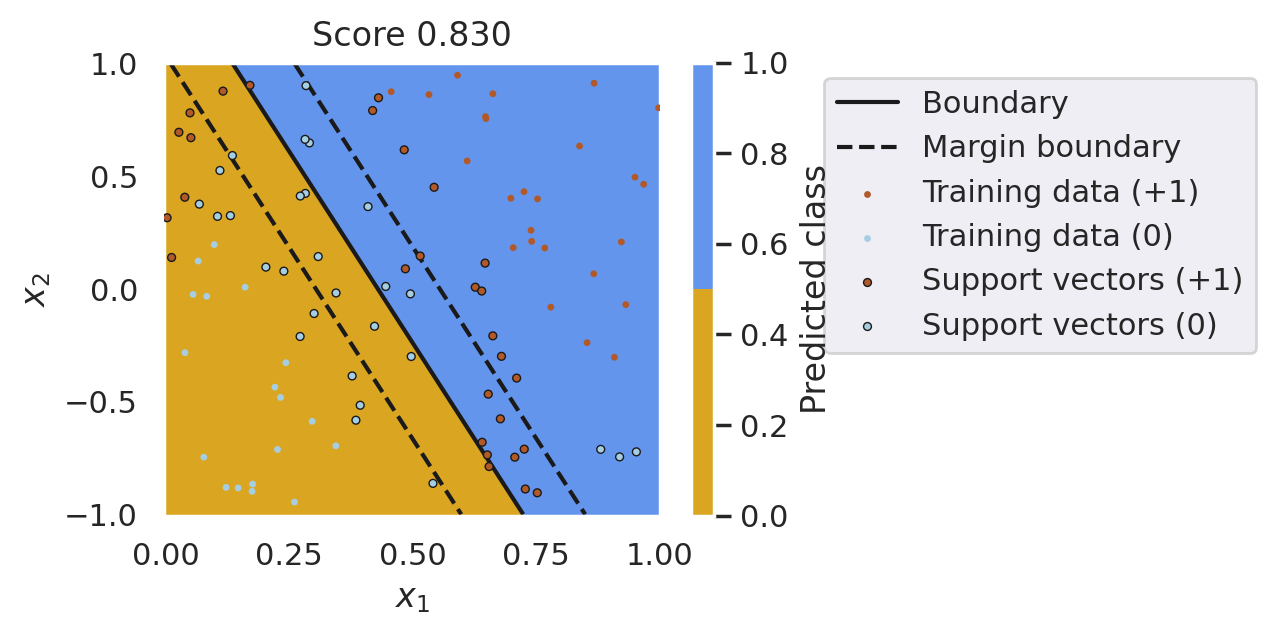

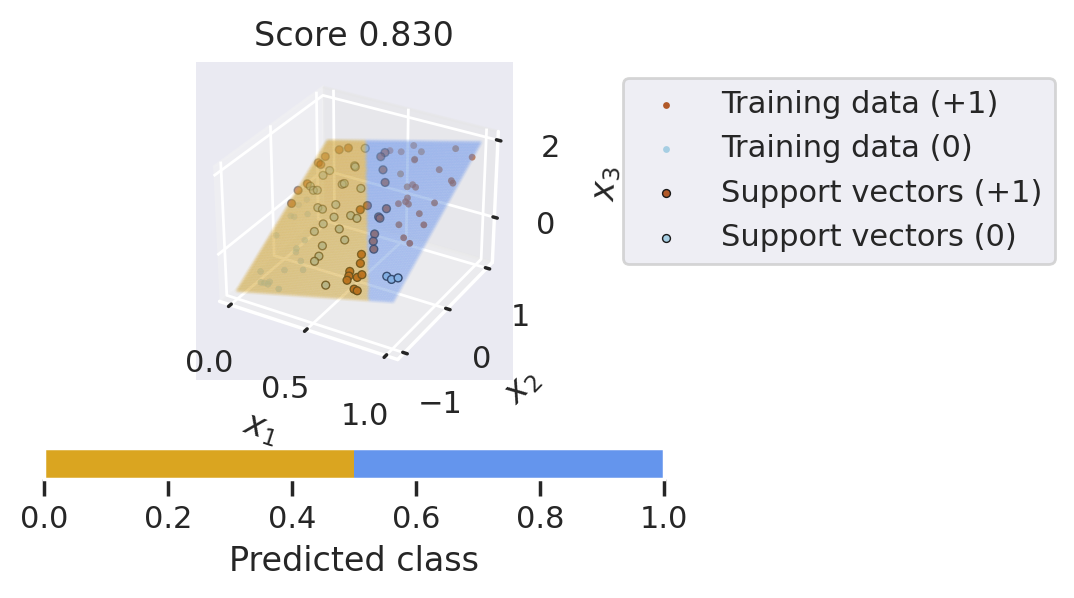

In [5]:
def transform(X_old):
    X = np.zeros((X_old.shape[0], X_old.shape[1]+1))
    X[:, :2] = X_old
    X[:, 2] = X_old[:, 0] + X_old[:, 1]
    
    return X

def custom_kernel(X1, X2):
    """
    X1: shape (n_samples_1, 2)
    X2: shape (n_samples_2, 2)
    
    return: (n_samples_1, n_samples_2)
    """
    X1 = transform(X1) # shape (n_samples_1, 3)
    X2 = transform(X2) # shape (n_samples_2, 3)
    
    K = np.dot(X1, X2.T)
    return K



# Generate random samples with the components 0 < x < 1, -1 < y < 1
X = np.random.rand(100, 2)
X[:, 1] = 2*(X[:, 1]-0.5)

y = classify(X, noise_amplitude=0.0, number_of_cycles=1.0, phase=0.0)

clf = svm.SVC(kernel=custom_kernel)
clf.fit(X, y)

visualize_clf(clf, X, y, show_decision_function=False)

visualize_clf_3d(clf, transform, X, y, show_decision_function = False)

## Task 3

Consider the case, in which you also have an unknown phase in the sin() function.
- Try the method developed in item 2 again. Explain why this does not work anymore (for non-zero phase).
- Try to find the appropriate kernel for the case of arbitrary phase, i.e. the transformation (to 4D) space that makes the trick. You should be able to observe a perfect separation.
  - You can define the transformation inside the custom kernel (the `visualize_clf` method will work as usual)
  - or apply the transformation to the training data

In [ ]:
# Define a new transform function here, that transforms into 4D
# ...


def custom_kernel(X1, X2):
    """
    X1: shape (n_samples_1, 2)
    X2: shape (n_samples_2, 2)
    
    return: (n_samples_1, n_samples_2)
    """
    X1 = transform(X1) # shape (n_samples_1, 3)
    X2 = transform(X2) # shape (n_samples_2, 3)
    
    K = np.dot(X1, X2.T)
    return K



# Generate random samples with the components 0 < x < 1, -1 < y < 1
X = np.random.rand(100, 2)
X[:, 1] = 2*(X[:, 1]-0.5)

y = classify(X, noise_amplitude=0.0, number_of_cycles=1.0, phase=0.3)

clf = svm.SVC(kernel=custom_kernel)
clf.fit(X, y)

visualize_clf(clf, X, y, show_decision_function=False)

## Task 4

Now, increase the level of noise. What does effectively happen with the solution? Discuss and make conclusions.